In [1]:
# We will do the imports required for this notebook here
%load_ext autoreload
%autoreload 2
# numpy provides import array and linear algebra utilities
import numpy as np

# the robotics toolbox provides robotics specific functionality
import roboticstoolbox as rtb
from pandaSim.geometry.utils import create_virtual_panda

# spatial math provides objects for representing transformations
import spatialmath as sm

# swift is a lightweight browser-based simulator which comes eith the toolbox
from swift import Swift

# spatialgeometry is a utility package for dealing with geometric objects
import spatialgeometry as sg

# import urchin to read urdf files
# from urchin import URDF

# this package provides several solvers for solving quadratic programmes
import qpsolvers as qp

# the os package provides utilities for interacting with the operating system
import os

# # import config 
# from config.config import *
# from models.panda_model import *


[I 07/17/25 12:30:26.931 24487] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


In [2]:
# Make a new environment and add objects
from pandaSim.geometry.rtb_adapter import RoboticsToolboxAdapter


adapter = RoboticsToolboxAdapter({
    "realtime": True,
    "rate": 100,
    "browser": 'google-chrome' # "notebook" for visualizing in jupyter notebook
})
    
env = adapter.env


panda_path = '../model/franka_description/robots/frankaEmikaPandaVirtual.urdf'

panda = create_virtual_panda(urdf_path=panda_path)

# We can then add our robot to the simulator envionment
env.add(panda)

# end-effector axes
ee_axes = sg.Axes(0.1)
ee_axes.T = panda.fkine(panda.q, end='panda_finger_virtual')

# goal axes
goal_axes = sg.Axes(0.1)

# Add the axes to the environment
env.add(ee_axes)
env.add(goal_axes) 

# Make a variable for the upper and lower limits of the robot
qd_lb = -np.pi * np.array([5/6]*4 + [1]*(panda.n-4))
qd_ub = np.pi * np.array([5/6]*4 + [1]*(panda.n-4))
panda.qdlim = np.vstack((qd_lb, qd_ub))


We can expand the above with velocity dampers to enable joint-position limit avoidance. Velocity dampers are used to constrain velocities and dampen an input velocity as some limit is approached. The velocity is only damped if it is within some influence distance to the limit. A joint velocity is constrained to prevent joint limits using a velocity damper as

\begin{align*} 
    \dot{q} \leq
    \eta
    \frac{\rho - \rho_s}
        {\rho_i - \rho_s}
    \qquad \text{if} \ \rho < \rho_i
\end{align*}

where $\rho \in \mathbb{R}^+$ is the distance or angle to the nearest joint limit, $\eta \in \mathbb{R}^+$ is a gain which adjusts the aggressiveness of the damper, $\rho_i$ is the influence distance in which to activate the damper, and $\rho_s$ is the stopping distance in which the distance $\rho$ will never be able to reach or enter. We can stack velocity dampers to perform joint position limit avoidance for each joint within a robot, and incorporate it into our QP as an inequality constraint

\begin{align*} 
    \bf{1}_n
    \dot{\bf{q}} &\leq
    \eta
    \begin{pmatrix}
        \frac{\rho_0 - \rho_s}
            {\rho_i - \rho_s} \\
        \vdots \\
        \frac{\rho_n - \rho_s}
            {\rho_i - \rho_s} 
    \end{pmatrix}
\end{align*}

where the identity $\bf{1}_n$ is included to show how the equation fits into the general form $\bf{A}\bf{x} \leq \bf{b}$ of an inequality constraint.

Lets make a Python method to construct these joint position limit velocity dampers

In [3]:
def joint_velocity_damper(robot, ps, pi, gain):
    """
    Formulates an inequality contraint which, when optimised for will
    make it impossible for the robot to run into joint limits. Requires
    the joint limits of the robot to be specified.

    ps: The minimum angle (in radians) in which the joint is
        allowed to approach to its limit
    pi: The influence angle (in radians) in which the velocity
        damper becomes active
    gain: The gain for the velocity damper

    returns: Ain, Bin as the inequality contraints for an qp
    """

    Ain = np.zeros((robot.n, robot.n))
    Bin = np.zeros(robot.n)
    for i in range(robot.n):
        if robot.q[i] - robot.qlim[0, i] <= pi:
            Bin[i] = -gain * (((robot.qlim[0, i] - robot.q[i]) + ps) / (pi - ps))
            Ain[i, i] = -1
        if robot.qlim[1, i] - robot.q[i] <= pi:
            Bin[i] = gain * ((robot.qlim[1, i] - robot.q[i]) - ps) / (pi - ps)
            Ain[i, i] = 1

    return Ain, Bin

It is possible that the robot will fail to reach the goal when the constraints create local minima. In such a scenario, the error $\bf{e}$ in the PBS scheme is no longer decreasing and the robot can no longer progress due to the constraints in the QP.

The methods shown up to this point require a redundant robot, where the number of joints is greater than 6. In [8], extra redundancy was introduced to the QP by relaxing the equality constraint in the QP to allow for intentional deviation from the desired end-effector velocity $\bf{\nu}$. The slack has the additional benefit of providing the solver extra flexibility to meet constraints and avoid local minima. The augmented QP is defined as

\begin{align*} 
    \min_x \quad f_o(\bf{x}) &= \frac{1}{2} \bf{x}^\top \mathcal{Q} \bf{x}+ \mathcal{C}^\top \bf{x}, \\ 
    \text{subject to} \quad \mathcal{J} \bf{x} &= \bf{\nu},  \\
    \mathcal{A} \bf{x} &\leq \mathcal{B},  \\
    \bf{x}^- &\leq \bf{x} \leq \bf{x}^+ 
\end{align*}

with

\begin{align*}
    \bf{x} &= 
    \begin{pmatrix}
        \dot{\bf{q}} \\ \bf{\delta}
    \end{pmatrix} \in \mathbb{R}^{(n+6)}  \\
    \mathcal{Q} &=
    \begin{pmatrix}
        \lambda_q \bf{1}_{n} & \mathbf{0}_{6 \times 6} \\ \mathbf{0}_{n \times n} & \lambda_\delta \bf{1}_{6}
    \end{pmatrix} \in \mathbb{R}^{(n+6) \times (n+6)} \\
    \mathcal{J} &=
    \begin{pmatrix}
        \bf{J}(\bf{q}) & \bf{1}_{6}
    \end{pmatrix} \in \mathbb{R}^{6 \times (n+6)} \\
    \mathcal{C} &= 
    \begin{pmatrix}
        \bf{J}_m \\ \bf{0}_{6 \times 1}
    \end{pmatrix} \in \mathbb{R}^{(n + 6)} \\
    \mathcal{A} &= 
    \begin{pmatrix}
        \bf{1}_{n \times n + 6} \\
    \end{pmatrix} \in \mathbb{R}^{(l + n) \times (n + 6)} \\
    \mathcal{B} &= 
    \eta
    \begin{pmatrix}
        \frac{\rho_0 - \rho_s}
                {\rho_i - \rho_s} \\
        \vdots \\
        \frac{\rho_n - \rho_s}
                {\rho_i - \rho_s} 
    \end{pmatrix} \in \mathbb{R}^{n} \\
    \bf{x}^{-, +} &= 
    \begin{pmatrix}
        \dot{\bf{q}}^{-, +} \\
        \bf{\delta}^{-, +}
    \end{pmatrix} \in \mathbb{R}^{(n+6)},
\end{align*}

where
$\bf{\delta} \in \mathbb{R}^6$ is the slack vector,
$\lambda_\delta \in \mathbb{R}^+$ is a gain term which adjusts the cost of the norm of the slack vector in the optimiser,
$\dot{\bf{q}}^{-,+}$ are the minimum and maximum joint velocities, and 
$\dot{\bf{\delta}}^{-,+}$ are the minimum and maximum slack velocities.
Each of the gains can be adjusted dynamically. For example, in practice $\lambda_\delta$ is typically large when far from the goal, but reduces towards 0 as the goal approaches.

The effect of this augmented optimisation problem is that the equality constraint is equivalent to

\begin{align*} 
    \bf{\nu}(t) - \bf{\delta}(t) = \bf{J}(\bf{q}) \dot{\bf{q}}(t)
\end{align*}

which clearly demonstrates that the slack is essentially intentional error, where the optimiser can choose to move components of the desired end-effector motion into the slack vector. For both redundant and non-redundant robots, this means that the robot may stray from the straight line motion to improve manipulability and avoid a singularity, avoid running into joint position limits, or stay bounded by the joint velocity limits.

Lets put this algorithm to the test in Python

In [4]:


env.set_camera_pose([1.3, 0, 0.4], [0, 0, 0.3])

box = sg.Cuboid(scale=[0.3, 0.07, 0.2],
                color='blue')
box.T = sm.SE3(0.7, 0, 0.1)
box.set_alpha(0.8)

# Change the robot configuration to a ready position
panda.q = panda.qr
panda.grippers[0].q = [0.035, 0.035]

env.add(panda)
env.add(box)
env.add(ee_axes)
env.add(goal_axes) 
# A variable to specify when to break the loop
arrived = False

# Specify the gain for the p_servo method
kt = 0.5
kr = 0.2
k = np.array([kt, kt, kt, kr, kr, kr])

# Specify our timestep
dt = 0.05

bTe = sm.SE3(-box.scale[0]/2 + 0.01, 0, 0) * sm.SE3.Rx(np.pi/2)
Tep = box.T * bTe * sm.SE3.Rz(0)

# Set the goal axes to Tep
goal_axes.T = Tep

# Set the gain on the manipulability maximisation
λm = 0.1

# Set the gain on the joint velocity norm minimisation
λq = 0.5


# Run the simulation until the robot arrives at the goal
while not arrived:

    # Work out the base frame manipulator Jacobian using the current robot configuration
    J = panda.jacob0(panda.q, end='panda_finger_virtual')

    # Calculate the manipulability Jacobian
    Jm = panda.jacobm(panda.q, axes='rot', end='panda_finger_virtual')

    # The end-effector pose of the panda (using .A to get a numpy array instead of an SE3 object)
    Te = panda.fkine(panda.q, end='panda_finger_virtual').A

    # Spatial error
    e = np.sum(np.abs(rtb.angle_axis(Te, Tep)))

    # Calculate the required end-effector velocity and whether the robot has arrived
    ev, arrived = rtb.p_servo(Te, Tep, gain=k, threshold=0.001, method="angle-axis")


    ### Calculate each component of the quadratic programme
    # Quadratic component of objective function
    Q = np.eye(panda.n + 6)

    # Joint velocity component of Q
    Q[:panda.n, :panda.n] *= λq

    # Slack component of Q
    Q[panda.n:, panda.n:] = (1 / e) * np.eye(6)

    # The equality contraints
    Aeq = np.c_[J, np.eye(6)]
    beq = ev.reshape((6,))

    # The inequality constraints for joint limit avoidance
    Ain = np.zeros((panda.n + 6, panda.n + 6))
    bin = np.zeros(panda.n + 6)

    # The minimum angle (in radians) in which the joint is allowed to approach
    # to its limit
    ps = 0.05

    # The influence angle (in radians) in which the velocity damper
    # becomes active
    pi = 0.3

    # The gain for the velocity damper
    k_qlim = 1.0

    # Form the joint limit velocity damper
    Ain[:panda.n, :panda.n], bin[:panda.n] = joint_velocity_damper(panda, ps, pi, k_qlim)

    # Linear component of objective function: the manipulability Jacobian
    c = np.r_[λm * -Jm.reshape((panda.n,)), np.zeros(6)]

    # The lower and upper bounds on the joint velocity
    lb = np.r_[qd_lb, -10 * np.ones(6)]
    ub = np.r_[qd_ub, 10 * np.ones(6)]

    # Solve for the joint velocities qd and apply to the robot
    xd = qp.solve_qp(Q, c, Ain, bin, Aeq, beq, lb=lb, ub=ub, solver='quadprog')

    # Apply the joint velocities to the Panda
    panda.qd[:panda.n] = xd[:panda.n]

    # Update the ee axes
    ee_axes.T = Te

    # Step the simulator by dt seconds
    env.step(dt)

In [51]:
from pandaSim.control.qp import QPController
from pandaSim.geometry.rtb_adapter import RoboticsToolboxAdapter

controller = QPController(adapter=adapter, 
                          gains_translation=0.5, 
                          gains_rotation=0.2, 
                          threshold=0.01, 
                          end_effector_link='panda_finger_virtual', 
                          lambda_q=1, 
                          lambda_m=0.1, 
                          lambda_j=0.1,
                          ps=0.5, 
                          pi=0.3, 
                          eta=1.0, 
                          solver='quadprog')
panda.q = panda.qr


J0 = panda.jacob0(panda.q, end='panda_finger_virtual')
H0 = panda.hessian0(J0=J0, end='panda_finger_virtual')



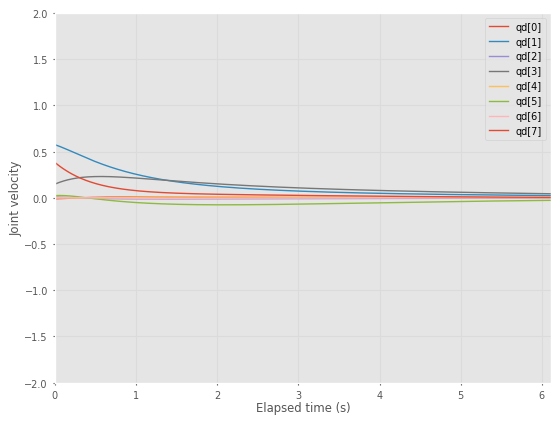

In [52]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

panda.q = panda.qr
arrived = False

qd_history = []
time_history = []

dt = 0.01
elapsed_time = 0.0

fig, ax = plt.subplots()
lines = [ax.plot([], [], label=f'qd[{i}]', linewidth=1)[0] for i in range(panda.n)]
ax.set_xlim(0, 20) 
ax.set_ylim(-2, 2)   
ax.set_xlabel('Elapsed time (s)')
ax.set_ylabel('Joint velocity')
ax.legend()
plt.ion()
plt.show()

step = 0
while not arrived:
    qd, arrived = controller.compute_joint_velocities(panda, Tep, optimization_type="j")
    adapter.control_joint_velocities(panda, qd)
    adapter.step_simulation(dt)
    qd_history.append(qd[:panda.n].copy())
    elapsed_time += dt
    time_history.append(elapsed_time)
    if step % 10 == 0:  # update plot every 0.1 seconds for speed
        clear_output(wait=True)
        for i, line in enumerate(lines):
            line.set_data(time_history, [q[i] for q in qd_history])
        ax.set_xlim(0, max(5, elapsed_time))
        display(fig)
    step += 1
plt.ioff()
plt.show()





In [ ]:
panda.q = panda.qr
Te = panda.fkine(panda.q, end='panda_finger_virtual').A
J0 = panda.jacob0(panda.q, end='panda_finger_virtual')
H0 = panda.hessian0(J0=J0, end='panda_finger_virtual')






ev, arrived = rtb.p_servo(Te, Tep, gain=k, threshold=0.001, method="angle-axis")
Jm = panda.jacobm(J=J0, H=H0, end='panda_finger_virtual', axes='rot')







ev, arrived, Jm, xd.shape

(array([ 8.79765923e-01,  2.58533660e-11, -1.98814888e+00,  9.15540735e-12,
         2.00000000e-01,  6.23310975e-12]),
 False,
 array([[-2.06986745e-27],
        [-8.67525946e-01],
        [ 4.08778030e-12],
        [ 8.65974849e-01],
        [ 2.95776718e-12],
        [-5.97762967e-01],
        [ 5.66364535e-12],
        [ 0.00000000e+00]]),
 (14,))